In [2]:
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from sklearn.metrics import log_loss, roc_auc_score, f1_score, accuracy_score
import sklearn.metrics as sk_metrics
from mlfinlab.clustering.feature_clusters import get_feature_clusters

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import xgboost as xgb

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
DATA_PATH = 'input/'

In [4]:
BATCH_SIZE = 8192
EPOCHS = 200
LR = 1e-3
WEIGHT_DECAY = 1e-5
EARLYSTOP_NUM = 3
nFOLDS = 5
device = torch.device('cuda')

In [5]:
TRAIN = False
CACHE_PATH ='models/'
print('Reading input data...')
train = pd.read_csv(f'{DATA_PATH}train.csv')
train = train.query('date > 85').reset_index(drop=True)
print('Optimizing memory usage...')
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns})
print('Complete')
features = [c for c in train.columns if 'feature' in c]
f_mean = train[features[1:]].mean()
train[features] = train[features].fillna(method='ffill').fillna(0)
train = train.query('weight > 0').reset_index(drop=True)
train['action'] = (train['resp'] > 0).astype('int') #BCE Target
train['action_1'] = (train['resp_1'] > 0).astype('int')
train['action_2'] = (train['resp_2'] > 0).astype('int')
train['action_3'] = (train['resp_3'] > 0).astype('int')
train['action_4'] = (train['resp_4'] > 0).astype('int')

Reading input data...
Optimizing memory usage...
Complete


In [6]:
target_cols = [target for target in train.columns if 'action' in target]
feat_cols= [col for col in features]
    
train['cross_41_42_43'] = train['feature_41'] + train['feature_42'] + train['feature_43']
    
train['cross_1_2'] = train['feature_1'] / (train['feature_2'] + 1e-5)
   
feat_cols.extend(['cross_41_42_43','cross_1_2'])

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=1111)

In [8]:
#Resnet
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d(len(feat_cols))
        self.dropout0 = nn.Dropout(0.2)

        dropout_rate = 0.2
        hidden_size = 256
        self.dense1 = nn.Linear(len(feat_cols), hidden_size)
        nn.init.kaiming_normal_(self.dense1.weight,mode='fan_out')
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense2 = nn.Linear(hidden_size+len(feat_cols), hidden_size)
        nn.init.kaiming_normal_(self.dense2.weight,mode='fan_out')
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
        nn.init.kaiming_normal_(self.dense3.weight,mode='fan_out')
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
        nn.init.kaiming_normal_(self.dense4.weight,mode='fan_out')
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.dense5 = nn.Linear(hidden_size+hidden_size, len(target_cols))
        nn.init.kaiming_normal_(self.dense5.weight,mode='fan_out')

        self.Relu = nn.ReLU(inplace=True)
        self.PReLU = nn.PReLU()
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        # self.GeLU = nn.GELU()
        self.RReLU = nn.RReLU()

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.dropout0(x)

        x1 = self.dense1(x)
        x1 = self.batch_norm1(x1)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x1 = self.LeakyReLU(x1)
        x1 = self.dropout1(x1)

        x = torch.cat([x, x1], 1)

        x2 = self.dense2(x)
        x2 = self.batch_norm2(x2)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x2 = self.LeakyReLU(x2)
        x2 = self.dropout2(x2)

        x = torch.cat([x1, x2], 1)

        x3 = self.dense3(x)
        x3 = self.batch_norm3(x3)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x3 = self.LeakyReLU(x3)
        x3 = self.dropout3(x3)

        x = torch.cat([x2, x3], 1)

        x4 = self.dense4(x)
        x4 = self.batch_norm4(x4)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x4 = self.LeakyReLU(x4)
        x4 = self.dropout4(x4)

        x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return x

In [9]:
class MarketDataset:
    def __init__(self, df):
        self.features = df[feat_cols].values

        self.label = df[target_cols].values.reshape(-1, len(target_cols))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float),
            'label': torch.tensor(self.label[idx], dtype=torch.float)
        }

In [10]:
test_set = train.query('date>400')

In [11]:
test_loader = DataLoader(MarketDataset(test_set),batch_size=BATCH_SIZE,shuffle=False)

In [12]:
model_list = []
for model in range(nFOLDS):
    resnet = Model().to(device)
    resnet_weights = f'{CACHE_PATH}model_v7_{model}.pkl'
    resnet.load_state_dict(torch.load(resnet_weights))
    resnet.eval()
    model_list.append(resnet)

In [13]:
def inference(model, dataloader, device):
    model.eval()
    preds = []
    val_loss = 0
    for data in tqdm(dataloader):
        X,y = data['features'].to(device),data['label'].to(device)
        with torch.no_grad():
            outputs = model(X)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
        
        
    preds = np.concatenate(preds).reshape(-1,len(target_cols))
    
    
    return preds

In [14]:
preds = np.zeros((len(test_set),len(target_cols)))
for model in model_list:
    preds += inference(model,test_loader,device)/len(model_list)
    

100%|██████████| 53/53 [00:10<00:00,  5.07it/s]


In [15]:
preds = np.median(preds,axis=1)

In [16]:
preds

array([0.53755017, 0.53074092, 0.50976699, ..., 0.47874612, 0.53868132,
       0.44762865])

In [17]:
actual = test_set['action'].values

In [18]:
def plot_roc(actual, prediction):
    # Calculate ROC / AUC
    fpr, tpr, thresholds = sk_metrics.roc_curve(actual, prediction, pos_label=1)
    roc_auc = sk_metrics.auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    plt.show()

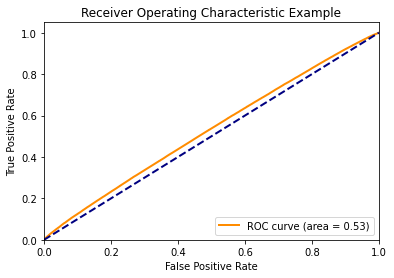

In [19]:
plot_roc(actual,preds)

In [20]:
thresh = 0.5
prediction_int = np.where(preds>=thresh,1,0)

In [21]:
#from keras.utils import to_categorical
meta_labels = prediction_int & actual

In [22]:
prediction_int = prediction_int.reshape((-1,1))
new_features = np.concatenate((prediction_int,test_set[feat_cols].values),axis=1)

In [23]:
new_features.shape

(433544, 133)

In [60]:
def _F1_eval(preds, labels):
    t = np.arange(0, 1, 0.005)
    f = np.repeat(0, 200)
    results = np.vstack([t, f]).T
    # assuming labels only containing 0's and 1's
    n_pos_examples = sum(labels)
    if n_pos_examples == 0:
        raise ValueError("labels not containing positive examples")

    for i in range(200):
        pred_indexes = (preds >= results[i, 0])
        TP = sum(labels[pred_indexes])
        FP = len(labels[pred_indexes]) - TP
        precision = 0
        recall = TP / n_pos_examples

        if (FP + TP) > 0:
            precision = TP / (FP + TP)

        if (precision + recall > 0):
            F1 = 2 * precision * recall / (precision + recall)
        else:
            F1 = 0
        results[i, 1] = F1
    return (max(results[:, 1]))

In [58]:
#XGBoost eval callback
def F1_eval(preds, dtrain):
    res = _F1_eval(preds, dtrain.get_label())
    return 'f1_err', 1-res

In [62]:
param_dist = {
    'objective':'binary:logistic',
    'n_estimators':300,
    'tree_method':'gpu_hist',
    'colsample_bytree':.1162
}

clf = xgb.XGBClassifier(**param_dist)


In [63]:
clf.fit(new_features,meta_labels,
       eval_set=[(new_features,meta_labels)],
       eval_metric=F1_eval,
       verbose=True)

[0]	validation_0-error:0.29316	validation_0-f1_err:0.96081
[1]	validation_0-error:0.29288	validation_0-f1_err:0.96908
[2]	validation_0-error:0.29211	validation_0-f1_err:0.96174
[3]	validation_0-error:0.29134	validation_0-f1_err:0.95430
[4]	validation_0-error:0.29124	validation_0-f1_err:0.94981
[5]	validation_0-error:0.29041	validation_0-f1_err:0.93106
[6]	validation_0-error:0.28944	validation_0-f1_err:0.91575
[7]	validation_0-error:0.28858	validation_0-f1_err:0.89749
[8]	validation_0-error:0.28838	validation_0-f1_err:0.89078
[9]	validation_0-error:0.28779	validation_0-f1_err:0.88091
[10]	validation_0-error:0.28166	validation_0-f1_err:0.75181
[11]	validation_0-error:0.28067	validation_0-f1_err:0.74688
[12]	validation_0-error:0.28021	validation_0-f1_err:0.73893
[13]	validation_0-error:0.27905	validation_0-f1_err:0.72858
[14]	validation_0-error:0.27843	validation_0-f1_err:0.71669
[15]	validation_0-error:0.27749	validation_0-f1_err:0.70931
[16]	validation_0-error:0.27692	validation_0-f1_er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1162, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [64]:
clf.save_model('XGB_Meta_Classifier_v4.json')

In [77]:
meta_XGB_preds = clf.predict(new_features)

In [79]:
#Consensus (Meta model & Resnet)
final_predictions = (meta_XGB_preds&prediction_int.flatten())

In [81]:
accuracy_score(actual,final_predictions)

0.6439115752957024

In [82]:
def utility_score_bincount(date, weight, resp, action):
    count_i = len(np.unique(date))
    # print('weight: ', weight)
    # print('resp: ', resp)
    # print('action: ', action)
    # print('weight * resp * action: ', weight * resp * action)
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return u

In [83]:
#Top LB scores ~11k... This is likely overfit (test set already seen by both models... Good for baseline/POC)
utility_score_bincount(date=test_set.date.values,weight=test_set.weight.values,
                                               resp=test_set.resp.values,action=final_predictions)

13524.74763396213